# Bitcoin price prediction

## Problem description
The problem presented in this notebook is the prediction of the price of Bitcoin. The dataset used in this notebook can be found online via: https://www.quandl.com/data/BCHARTS/KRAKENUSD-Bitcoin-Markets-krakenUSD .

## Implementation
This notebook tries to solve the problem using a Reccurent Neural Network (RNNs), and, more specifically, Long Short Term Memory networks (LSTMs).
### RNNs
RNNs make use of sequential information, its output  being dependent on the previous computations. A way to think about them is that they have a "memory" which captures information about what has been calculated so far. The problem with RNNs is that the amount of past information it can hold is limited. In the case of Bitcoin prices, it would be useful to have a large amount of past prices. This is where LSTMs become useful.
### LSTMs
LSTMs or Long Short Memory Networks are a special kind of RNN, capable of learning long-term dependencies. They are explicitly designed to avoid the long-term dependency problem that the RNNs have.

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

## Data fetching & statistics

In [2]:
dataframe = pd.read_csv(filepath_or_buffer = "BCHARTS-KRAKENUSD.csv")
dataframe = dataframe.iloc[::-1]

dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2689 entries, 2688 to 0
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               2689 non-null   object 
 1   Open               2689 non-null   float64
 2   High               2689 non-null   float64
 3   Low                2689 non-null   float64
 4   Close              2689 non-null   float64
 5   Volume (BTC)       2689 non-null   float64
 6   Volume (Currency)  2689 non-null   float64
 7   Weighted Price     2689 non-null   float64
dtypes: float64(7), object(1)
memory usage: 168.2+ KB


In [3]:
dataframe.describe()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
count,2689.000000,2689.000000,2689.000000,2689.000000,2689.000000,2.689000e+03,2689.000000
mean,6763.144698,6976.471788,6517.329513,6772.348286,3780.178657,4.195755e+07,6755.894797
std,11086.022617,11451.426148,10634.910731,11091.484565,4374.233252,8.691776e+07,11068.481727
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,479.997990,500.000000,465.001430,475.006510,86.532707,2.753809e+04,477.180242
50%,3560.100000,3632.200000,3468.700000,3562.300000,2717.600653,1.356895e+07,3551.134905
75%,8712.800000,8933.700000,8421.000000,8716.500000,5630.447920,4.503784e+07,8665.858389
max,63581.000000,64900.000000,62050.000000,63587.200000,45110.873425,1.237786e+09,63326.470550


In [4]:
dataframe.tail()

,Date,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
4,2021-05-23,37474.8,38269.7,31078.7,34718.8,14832.738515,5.050181e+08,34047.528311
3,2021-05-24,34718.8,39989.9,34420.8,38833.8,11058.707601,4.155683e+08,37578.380688
2,2021-05-25,38843.0,39841.8,36500.0,38388.1,9236.125577,3.505080e+08,37949.674385
1,2021-05-26,38373.3,40893.6,37828.7,39283.9,9233.565257,3.624884e+08,39257.680017
0,2021-05-27,39290.0,40398.0,37230.0,38603.5,5757.923466,2.233911e+08,38797.164686


## Data modification

What I am trying to predict is the Weighted Price column. To make it easier, I will extract the column into a separate DataFrame object and I will set its index column to the Date column which will be in datetime format.

In [5]:
dataframe_price = pd.DataFrame(dataframe['Weighted Price'])
dataframe_price.index = pd.to_datetime(dataframe['Date'])
print(dataframe_price.index)
print()
print(dataframe_price)

DatetimeIndex(['2014-01-07', '2014-01-08', '2014-01-09', '2014-01-10',
               '2014-01-11', '2014-01-12', '2014-01-13', '2014-01-14',
               '2014-01-15', '2014-01-16',
               ...
               '2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
               '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
               '2021-05-26', '2021-05-27'],
              dtype='datetime64[ns]', name='Date', length=2689, freq=None)

            Weighted Price
Date                      
2014-01-07      841.835522
2014-01-08      839.156269
2014-01-09      831.572913
2014-01-10      844.938794
2014-01-11      890.671709
...                    ...
2021-05-23    34047.528311
2021-05-24    37578.380688
2021-05-25    37949.674385
2021-05-26    39257.680017
2021-05-27    38797.164686

[2689 rows x 1 columns]


In [6]:
dataframe_price.describe()

,Weighted Price
count,2689.000000
mean,6755.894797
std,11068.481727
min,0.000000
25%,477.180242
50%,3551.134905
75%,8665.858389
max,63326.470550


As it can be seen in the min row, there are some dates with 0 Weighted Price. To fix this, we will replace replace every 0 value with the previous non-zero value.

In [7]:
dataframe_price.replace(to_replace = 0, method = 'ffill', inplace = True)
dataframe_price.describe()

,Weighted Price
count,2689.000000
mean,6765.569675
std,11063.393706
min,199.628389
25%,488.077565
50%,3551.464453
75%,8665.858389
max,63326.470550


## Data visualization

<AxesSubplot:xlabel='Date'>

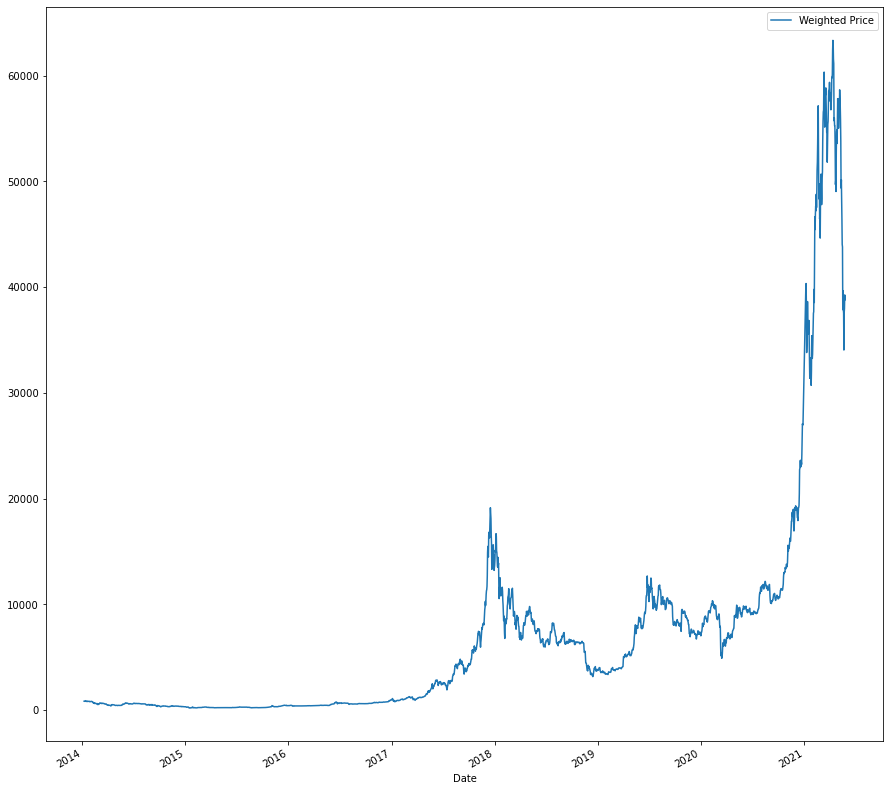

In [8]:
dataframe_price.plot(figsize = (15, 15))

## Data splitting

In [9]:
test_size = 150

df_train = dataframe_price[: len(dataframe_price) - test_size]
trainset = df_train.values

df_test = dataframe_price[len(dataframe_price) - test_size :]
testset = df_test.values
pred_input = testset

trainset

array([[  841.8355223 ],
       [  839.15626937],
       [  831.57291257],
       ...,
       [22738.61136594],
       [22855.91137875],
       [23557.57947433]])

## Data scaling

In [10]:
scaler = MinMaxScaler()

trainset = scaler.fit_transform(trainset)
pred_input = scaler.transform(pred_input)

print(trainset)

X_train = trainset[0 : len(trainset) - 1]
y_train = trainset[1 : len(trainset)]

[[0.02749416]
 [0.02737945]
 [0.02705479]
 ...
 [0.96493836]
 [0.9699602 ]
 [1.        ]]


## Reshape for keras

In [15]:
X_train = np.reshape(X_train, (len(X_train), 1, 1))
pred_input = np.reshape(pred_input, (len(pred_input), 1, 1))

## Model fitting

In [12]:
model = Sequential()

model.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))
#model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, batch_size = 5, epochs = 100)

Epoch 1/100
508/508 [==============================] - 1s 1ms/step - loss: 0.0317
Epoch 2/100
508/508 [==============================] - 1s 1ms/step - loss: 0.0200
Epoch 3/100
508/508 [==============================] - 1s 1ms/step - loss: 0.0109
Epoch 4/100
508/508 [==============================] - 1s 1ms/step - loss: 0.0043
Epoch 5/100
508/508 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 6/100
508/508 [==============================] - 1s 1ms/step - loss: 2.5946e-04
Epoch 7/100
508/508 [==============================] - 1s 1ms/step - loss: 1.5393e-04
Epoch 8/100
508/508 [==============================] - 1s 1ms/step - loss: 1.4691e-04
Epoch 9/100
508/508 [==============================] - 1s 1ms/step - loss: 1.4588e-04
Epoch 10/100
508/508 [==============================] - 1s 1ms/step - loss: 1.4439e-04
Epoch 11/100
508/508 [==============================] - 1s 1ms/step - loss: 1.4378e-04
Epoch 12/100
508/508 [==============================] - 1s 1ms/step - lo

508/508 [==============================] - 1s 1ms/step - loss: 1.1363e-04
Epoch 96/100
508/508 [==============================] - 1s 1ms/step - loss: 1.1203e-04
Epoch 97/100
508/508 [==============================] - 1s 1ms/step - loss: 1.1449e-04
Epoch 98/100
508/508 [==============================] - 1s 2ms/step - loss: 1.1441e-04
Epoch 99/100
508/508 [==============================] - 1s 1ms/step - loss: 1.1460e-04
Epoch 100/100
508/508 [==============================] - 1s 1ms/step - loss: 1.1499e-04


## Prediction

In [13]:
predicted_price = model.predict(pred_input)
predicted_price = scaler.inverse_transform(predicted_price)

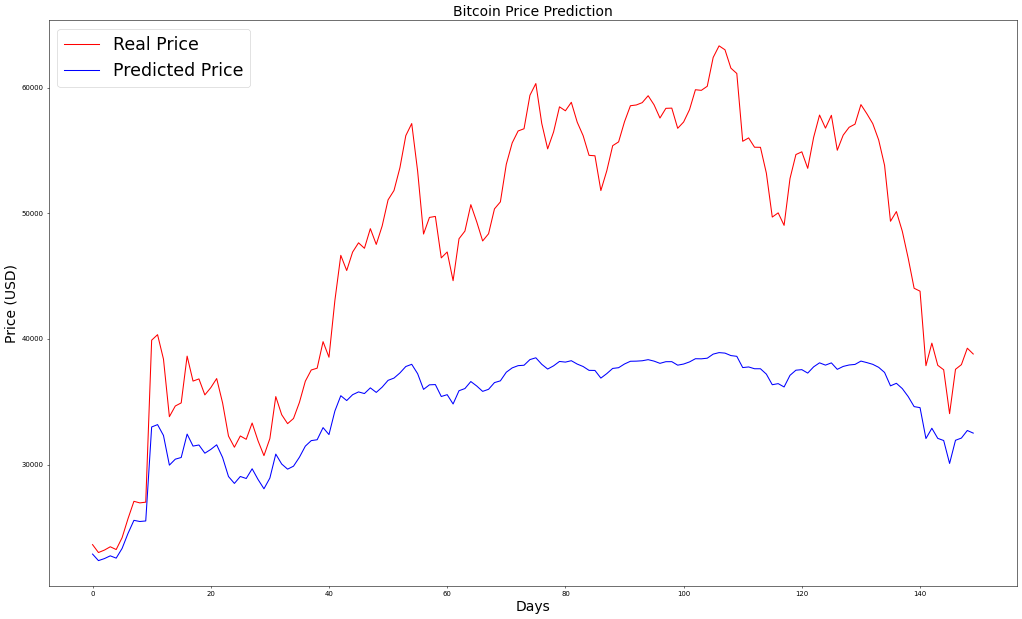

In [14]:
plt.figure(figsize=(25,15), dpi=50, facecolor='w', edgecolor='k')  
plt.plot(testset, color = 'red', label = 'Real Price')
plt.plot(predicted_price, color = 'blue', label = 'Predicted Price')
plt.title('Bitcoin Price Prediction', fontsize=20)
plt.xlabel('Days', fontsize=20)
plt.ylabel('Price (USD)', fontsize=20)
plt.legend(loc=2, prop={'size': 25})
plt.show()